# Cascade Click Model に適用する Bandit Algorithms 実装

In [1]:
import math
import random
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm

/Users/hiromu.nakamura/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
np.random.seed(0)

In [3]:
class Agent(ABC):
	@abstractmethod
	def get_list(self, k: int) -> list[int]:
		pass

	@abstractmethod
	def observe(self, a: list[int], click : int) -> None:
		pass

class Env(ABC):
	@abstractmethod
	def click(self, A: list[int]) -> int:
		pass
	
	@abstractmethod
	def weights(self, A: list[int]) -> list[float]:
		pass

	@abstractmethod
	def optimal_weights(self, k: int) -> list[float]:
		pass

In [4]:
class CascadingModelEnv(Env):
	def __init__(self, E: list[float]):
		self.E = E

	def click(self, A: list[int]) -> int:
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				return i+1
		return -1

	def weights(self, A: list[int]) -> list[float]:
		return [self.E[i] for i in A]

	def optimal_weights(self, k: int) -> list[float]:
		return sorted(E, reverse=True)[:k]

In [5]:
def f(weights: list[float]) -> float:
	v = 1
	for w in weights:
		v *= (1-w)
	return 1-v

def regret(optimal_weights: list[float], weights: list[float]) -> float:
	return f(optimal_weights) - f(weights)

In [6]:
def simulate(agent: Agent, env: Env, k: int, steps: int) -> list[float]:
	optimal_weights = env.optimal_weights(k=k)

	cumulative_regret = 0
	regret_cumulative_history = []
	for i in tqdm(range(steps)):
		a = agent.get_list(k=k)
		click = env.click(a)
		agent.observe(a, click)

		setting_weights = env.weights(a)
		cumulative_regret += regret(optimal_weights, setting_weights)
		regret_cumulative_history.append(cumulative_regret)

	return regret_cumulative_history

## CascadeUCB1

In [7]:
class CascadeUCB1Agent(Agent):
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int):
    return self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e])

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.is_click(click, i+1) ) / self.counts[e]

In [8]:
# E = [0.3, 0.2, 0.25, 0.1, 0.1, 0.24, 0.2, 0.1, 0.21, 0.1]
# env = CascadingModelEnv(E=E)
# agent = CascadeUCB1Agent(E=E, p=0.2)

# regret_cumulative_history = simulate(agent=agent, env=env, k=3, steps=100000)

# plt.xlabel("step t")
# plt.ylabel("Regret")
# plt.plot(regret_cumulative_history)

## CascadeLinTS

In [9]:
class CascadeLinTSAgent(Agent):
  def __init__(self, d: int, sigma: float, features: pd.DataFrame):
    self.sigma = sigma
    self.features = features
    self.InvM = np.eye(d)
    self.B = np.zeros(d)

  def get_list(self, k: int) -> list[int]:
    before_theta = (self.sigma**-2) * np.inner(self.InvM, self.B)
    theta = np.random.multivariate_normal(before_theta, cov=self.InvM)
    weights = self.features['feature'].apply(lambda x: np.inner(x.T, theta)).to_list()
    return sorted(range(len(weights)), key=lambda i: weights[i], reverse=True)[:k]

  def is_click(self, click: int, k: int) -> int:
    return 1 if click == k else 0

  def observe(self, a: list[int], click : int) -> None:
    if click == -1:
      click = len(a)

    for i in range(min(len(a), click)):
      e = a[i]
      x = self.features[self.features['id']==e]['feature'].to_list()[0]
      self.InvM = self.InvM - (self.InvM * x * x.T * self.InvM)/(x.T * self.InvM * x + self.sigma)
      if self.is_click(click, i+1):
        self.B = self.B + x

## EXPERIMENTS

CascadeUCB1とCascadeLinTSの比較

In [10]:
def gen_items(tags: dict[str, float], L: int, sigma=0.01)-> pd.DataFrame:
  tag_ids = list(tags.keys())
  weights = []
  features = []
  for i in range(L):
    n = random.randint(1, 3)
    tag_samples = random.sample(tag_ids, n)

    w = 0
    one_hot = []
    for t in tag_ids:
      if t in tag_samples:
        w += random.gauss(tags[t], sigma)
        one_hot.append(1)
      else:
        one_hot.append(0)
      
    features.append(np.array(one_hot))
    weights.append(w)

  df = pd.DataFrame({'id': list(range(len(weights))),
                      'weight' : weights,
                      'feature' : features})
  return  df

In [11]:
k=4
L=[16, 256, 3000]
steps=10000

100%|██████████| 10000/10000 [01:34<00:00, 106.21it/s]


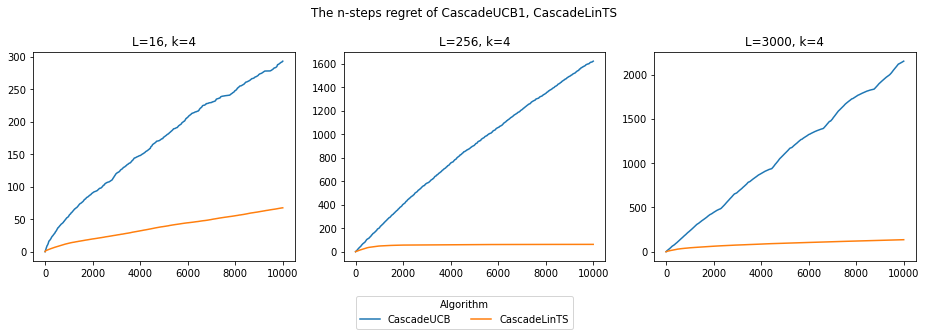

In [12]:
tags_with_weight = {'AWS': 0.03, 'Docker': 0.2,'Elasticsearch': 0.15 ,'GCP': 0.08, 'Git': 0.05, 'NLP': 0.19, 'Rust': 0.23, 'Scala': 0.14, '機械学習': 0.15, '強化学習': 0.20}

fig = plt.figure(figsize=(13,4))
fig.suptitle('The n-steps regret of CascadeUCB1, CascadeLinTS')

for i, l in enumerate(L):
	df = gen_items(tags=tags_with_weight, L=l)
	E = df['weight'].to_list()

	env = CascadingModelEnv(E=E)

	cascadelints_agent = CascadeLinTSAgent(d=len(tags_with_weight), sigma=1, features=df.drop('weight', axis=1))
	cascadeucb_agent = CascadeUCB1Agent(E=E, p=0.2)

	cascadeucb_regret_cumulative_history = simulate(agent=cascadeucb_agent, env=env, k=k, steps=steps)
	cascadelints_regret_cumulative_history = simulate(agent=cascadelints_agent, env=env, k=k, steps=steps)

	ax = fig.add_subplot(1,3,i+1)
	ax.set_title(f'L={l}, k=4')
	ax.plot(cascadeucb_regret_cumulative_history, label='CascadeUCB')
	ax.plot(cascadelints_regret_cumulative_history, label='CascadeLinTS')

fig.legend(['CascadeUCB', 'CascadeLinTS'], loc='upper center', borderaxespad=0.1, title="Algorithm", bbox_to_anchor=(0.5, -0.02), ncol=2)
fig.tight_layout()
plt.show()